In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from datetime import datetime

import tarfile
import gzip
import os
import xml.etree.ElementTree as ET

In [129]:
data_folder = './data/MovieSummaries/'

'''
Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)
'''
movie_metadata = pd.read_table(data_folder + 'movie.metadata.tsv', header=None)
movie_metadata.columns = ['wiki_movie_id','free_movie_id','movie_name','release_date','box_office_revenue',
                          'runtime','languages','countries','genres']

'''
Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID
'''
character_metadata = pd.read_table(data_folder + 'character.metadata.tsv', header=None)
character_metadata.columns = ['wiki_movie_id','free_movie_id','release_date','character_name',
                              'actor_birth_date','actor_gender','actor_height','actor_ethnicity','actor_name',
                              'actor_age','free_character_actor_map_id','free_character_id','free_actor_id']

'''
970 unique character names used in at least two different movies, along with 2,666 instances of those types.
The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.
'''
name_clusters = pd.read_csv(data_folder + 'name.clusters.txt', sep="\t", header=None)
name_clusters.columns = ['character_name', 'free_character_actor_map_id']

'''
Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.
Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.
'''
plot_summaries = pd.read_csv(data_folder + 'plot_summaries.txt', sep='\t', header=None)
plot_summaries.columns = ['wiki_movie_id', 'plot']

'''
72 character types drawn from tvtropes.com, along with 501 instances of those types.
The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.
'''
test_data = pd.read_csv(data_folder + 'tvtropes.clusters.txt', sep='\t', header=None)
test_data.columns = ['character_type', 'dictionary']
test_data['dictionary'] = test_data['dictionary'].apply(eval)
test_data['character_name'] = test_data.dictionary.apply(lambda x: x['char'])
test_data['movie_name'] = test_data.dictionary.apply(lambda x: x['movie'])
test_data['free_character_actor_map_id'] = test_data.dictionary.apply(lambda x: x['id'])
test_data['actor_name'] = test_data.dictionary.apply(lambda x: x['actor'])

In [161]:
movie_metadata.head()

,wiki_movie_id,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [152]:
character_metadata.head()

,wiki_movie_id,free_movie_id,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,free_character_actor_map_id,free_character_id,free_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [153]:
name_clusters.head()

,character_name,free_character_actor_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [154]:
plot_summaries.head()

,wiki_movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [155]:
test_data.head()                                         

,character_type,dictionary,character_name,movie_name,free_character_actor_map_id,actor_name
0,absent_minded_professor,"{'char': 'Professor Philip Brainard', 'movie':...",Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,"{'char': 'Professor Keenbean', 'movie': 'Richi...",Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,"{'char': 'Dr. Reinhardt Lane', 'movie': 'The S...",Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,"{'char': 'Dr. Harold Medford', 'movie': 'Them!...",Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,"{'char': 'Daniel Jackson', 'movie': 'Stargate'...",Daniel Jackson,Stargate,/m/0k3rhh,James Spader


In [157]:
# character_metadata.loc[character_metadata['character_name'] == 'Stuart Little']

In [116]:
print(character_metadata['free_character_actor_map_id'].unique)
print(character_metadata['free_character_actor_map_id'])

# column 11. Freebase character/actor map ID: is it useful? unique value for each row
# in name_clusters, test_data 

<bound method Series.unique of 0         /m/0bgchxw
1          /m/0jys3m
2          /m/0jys3g
3         /m/02vchl6
4         /m/02vbb3r
             ...    
450664    /m/0kr406c
450665    /m/0kr405_
450666    /m/0g8ngmc
450667    /m/0g8ngmj
450668    /m/0g8ngmw
Name: free_character_actor_map_id, Length: 450669, dtype: object>
0         /m/0bgchxw
1          /m/0jys3m
2          /m/0jys3g
3         /m/02vchl6
4         /m/02vbb3r
             ...    
450664    /m/0kr406c
450665    /m/0kr405_
450666    /m/0g8ngmc
450667    /m/0g8ngmj
450668    /m/0g8ngmw
Name: free_character_actor_map_id, Length: 450669, dtype: object


In [150]:
'''
The plot summaries from above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref).
Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).
'''

data_folder = './data/corenlp_plot_summaries/'
df = pd.read_xml(data_folder + '330.xml.gz', compression='gzip',) # NaN

'''
# error
directory = './data/corenlp_plot_summaries/'
gz_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.gz')]
data_frames = []
for gz_file in gz_files:
    with gzip.open(gz_file) as f:
        df = pd.read_csv(f, compression='gzip')
        data_frames.append(df)
'''

# df

"\n# error\ndirectory = './data/corenlp_plot_summaries/'\ngz_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.gz')]\ndata_frames = []\nfor gz_file in gz_files:\n    with gzip.open(gz_file) as f:\n        df = pd.read_csv(f, compression='gzip')\n        data_frames.append(df)\n"

In [148]:
# manual parsing ...

# Parse the XML data
f = gzip.open(data_folder + '330.xml.gz')
tree = ET.parse(f)
root = tree.getroot()

# Create empty lists to store the data
data = {
    'word': [],
    'lemma': [],
    'CharacterOffsetBegin': [],
    'CharacterOffsetEnd': [],
    'POS': [],
    'NER': [],
}

# Iterate through the XML structure to extract the data
for token in root.findall(".//token"):
    data['word'].append(token.find('word').text)
    data['lemma'].append(token.find('lemma').text)
    data['CharacterOffsetBegin'].append(int(token.find('CharacterOffsetBegin').text))
    data['CharacterOffsetEnd'].append(int(token.find('CharacterOffsetEnd').text))
    data['POS'].append(token.find('POS').text)
    data['NER'].append(token.find('NER').text)

# Create a DataFrame from the extracted data
df = pd.DataFrame(data)

# Display the DataFrame
#df

In [231]:
movie_metadata.head()

,wiki_movie_id,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [188]:
# first analysis

print('number of nan values in movie_metadata:')
print(movie_metadata.isna().sum())
# a lot of box_office_revenue NaN

print('\nnumber of rows in movie_metadata')
print(movie_metadata.shape[0])

number of nan values in movie_metadata:
wiki_movie_id             0
free_movie_id             0
movie_name                0
release_date           6902
box_office_revenue    73340
runtime               20450
languages                 0
countries                 0
genres                    0
dtype: int64

number of rows in movie_metadata
81741


In [266]:
def extract_year(date_str):
    if date_str is None or date_str == "":
        return None  # or handle it in your desired way

    # Check if the input is NaN (float NaN)
    if isinstance(date_str, float) and math.isnan(date_str):
        return None  # Handle NaN as needed

    # Convert the input to a string if it's a float
    if isinstance(date_str, float):
        date_str = str(date_str)  # Assuming it's a float representing a year

    try:
        date = datetime.strptime(date_str, "%Y")
        return date.year
    except ValueError:
        try:
            date = datetime.strptime(date_str, "%Y-%m")
            return date.year
        except ValueError:
            try:
                date = datetime.strptime(date_str, "%Y-%m-%d")
                return date.year
            except ValueError:
                return None

### float year

movie_metadata['release_year'] = movie_metadata['release_date'].apply(lambda x: extract_year(x))
movie_metadata.head()


,wiki_movie_id,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres,release_year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0


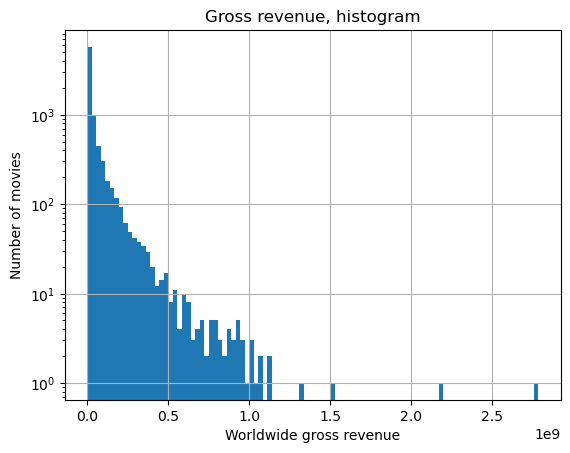

In [196]:
movie_metadata['box_office_revenue'].dropna().hist(bins = 100, log=True)
plt.xlabel('Worldwide gross revenue')
plt.ylabel('Number of movies')
plt.title('Gross revenue, histogram');

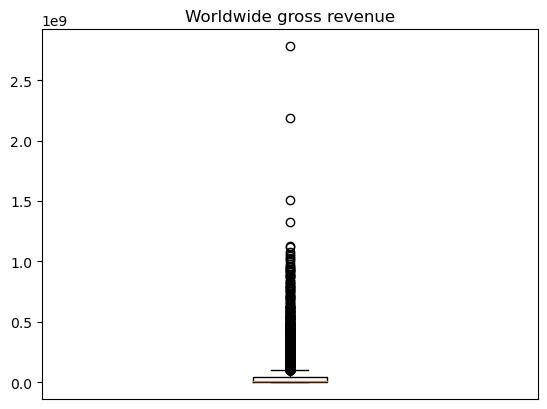

In [199]:
plt.boxplot(movie_metadata['box_office_revenue'].dropna())
plt.xticks([])
plt.title('Worldwide gross revenue');

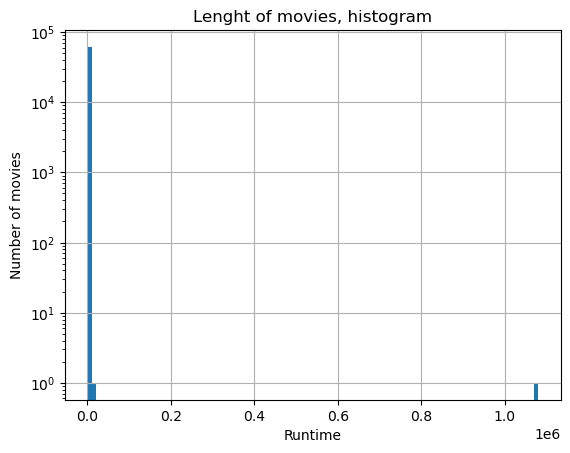

In [203]:
movie_metadata['runtime'].dropna().hist(bins = 100, log=True)
plt.xlabel('Runtime')
plt.ylabel('Number of movies')
plt.title('Lenght of movies, histogram');

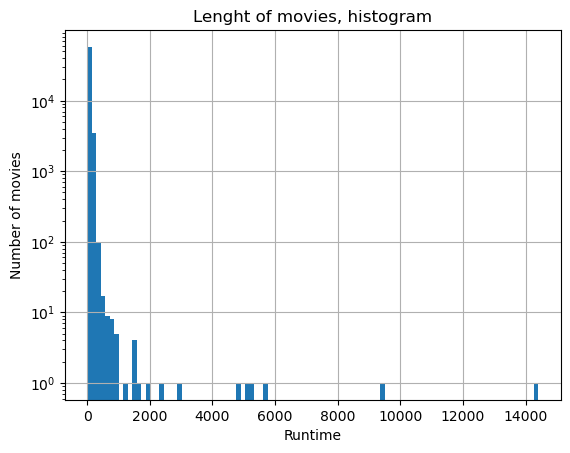

In [274]:
movie_metadata[movie_metadata['runtime'] < 1079280].runtime.dropna().hist(bins = 100, log=True)
plt.xlabel('Runtime')
plt.ylabel('Number of movies')
plt.title('Lenght of movies, histogram');

In [ ]:
movie_metadata[movie_metadata['runtime'] > 14000]
# movie 10815585, error runtime

,wiki_movie_id,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
12804,10815585,/m/02qqy23,Zero Tolerance,1995,NaN,1079281.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F..."
62962,32441022,/m/0gyr803,Modern Times Forever,NaN,NaN,14400.0,{},{},"{""/m/0jtdp"": ""Documentary""}"


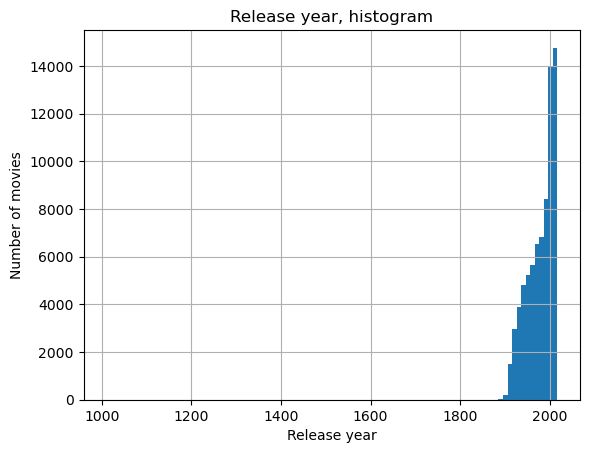

In [270]:
movie_metadata['release_year'].dropna().hist(bins = 100, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of movies')
plt.title('Release year, histogram');